In [1]:
import sys
from pathlib import Path
import pandas as pd

sys.path.append('/home/denisova/micro/code/shortgun/src/utils')

from config import load_config

config = load_config('/home/denisova/micro/code/config.yaml')
data_dir = Path(config['data_dir'])
output_dir = Path(config['output_dir'])
tax_levels = config.get('tax_levels', ['species'])

In [2]:
data_orig = {}
data_pca = {}

for tax in tax_levels: 
    dataframe = pd.read_csv(
        output_dir / f'data_processed/abundance_{tax}.csv', sep=',', index_col = "sampleid"
    )
    data_orig[tax] = dataframe

    df = pd.read_csv(
        output_dir / f'pca/abundance_{tax}.csv', sep=';', header=None
    )
    df.index = dataframe.index

    data_pca[tax] = df

In [3]:
anketa = pd.read_csv(
    data_dir / "anketa_data_vdWGS.tsv", 
    sep = "\t",
    low_memory=False
)

anketa_diseases = anketa[["tubeid", "icd10Diseases"]]
anketa_diseases = anketa_diseases.fillna("[]")
anketa_diseases["T2D"] = anketa_diseases["icd10Diseases"].apply(
    lambda x: "E11" in x
)

anketa_diseases.head()

,tubeid,icd10Diseases,T2D
0,do6584,['E06'],False
1,fx9617,"['G43', 'J18', 'N30', 'E80.4']",False
2,lo7204,"['L40', 'L70.0', 'E03.9', 'F17.2']",False
3,ma3578,"['K29', 'J03', 'K26', 'A37', 'J35']",False
4,ow2218,[],False


In [10]:
from sklearn.utils import resample
from collections import defaultdict

df_false = anketa_diseases[anketa_diseases["T2D"] == False]
df_true = anketa_diseases[anketa_diseases["T2D"] == True]

df_false_downsampled = resample(df_false, 
                               replace=False, 
                               n_samples=len(df_true), 
                               random_state=42)

X_balanced = pd.concat([df_false_downsampled, df_true])

test_index = defaultdict(dict)

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score, roc_curve
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

def get_log_reg_for_taxa(taxa, anketa_diseases=anketa_diseases, data_orig=data_orig, dataset_name="data_orig"):
    print(
        f"""
        -------------------------
        Analysis for tax: {taxa}
        -------------------------
        """
    )

    common_index = set(anketa_diseases["tubeid"]) & set(data_orig[taxa].index)

    anketa_diseases_filtered = anketa_diseases[anketa_diseases["tubeid"].apply(lambda x: x in common_index)].copy().sort_values(by = "tubeid")

    data_orig_taxa = data_orig[taxa].copy()
    data_orig_taxa_filtered = data_orig_taxa[data_orig_taxa.index.isin(common_index)].copy().sort_index()

    print(f"We analyse data of shape {data_orig_taxa_filtered.shape}\n")

    X = data_orig_taxa_filtered.values
    y = anketa_diseases_filtered["T2D"]

    model = LogisticRegression(class_weight='balanced', max_iter=1000)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, stratify=y, test_size=0.2, random_state=42
    )

    test_index[dataset_name][tax] = y_test

    scaler = StandardScaler().fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)[:, 1]

    print(classification_report(y_test, y_pred))
    print("ROC AUC:", round(roc_auc_score(y_test, y_prob), 4))
    print("PR AUC:", round(average_precision_score(y_test, y_prob), 4))

    fpr, tpr, _ = roc_curve(y_test, y_prob)

    plt.plot(fpr, tpr, label='ROC Curve (AUC = %.2f)' % roc_auc_score(y_test, y_prob))
    plt.plot([0,1], [0,1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.title('ROC Curve')
    plt.show()


        -------------------------
        Analysis for tax: order
        -------------------------
        
We analyse data of shape (568, 43)



              precision    recall  f1-score   support

       False       0.60      0.59      0.59        56
        True       0.61      0.62      0.62        58

    accuracy                           0.61       114
   macro avg       0.61      0.60      0.60       114
weighted avg       0.61      0.61      0.61       114

ROC AUC: 0.6155
PR AUC: 0.6264


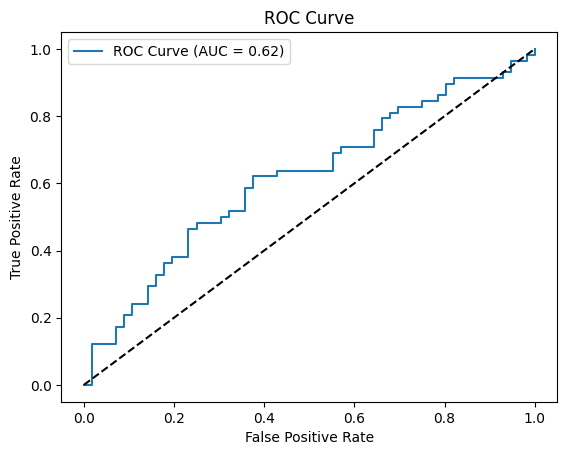


        -------------------------
        Analysis for tax: family
        -------------------------
        
We analyse data of shape (568, 53)

              precision    recall  f1-score   support

       False       0.62      0.62      0.62        56
        True       0.64      0.64      0.64        58

    accuracy                           0.63       114
   macro avg       0.63      0.63      0.63       114
weighted avg       0.63      0.63      0.63       114

ROC AUC: 0.6693
PR AUC: 0.6818


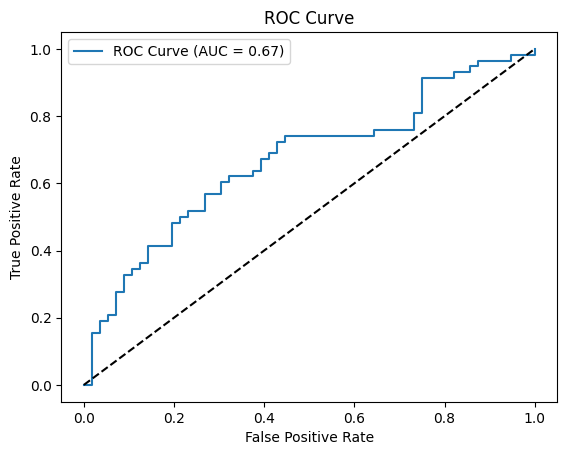


        -------------------------
        Analysis for tax: genus
        -------------------------
        
We analyse data of shape (568, 85)

              precision    recall  f1-score   support

       False       0.64      0.62      0.63        56
        True       0.64      0.66      0.65        58

    accuracy                           0.64       114
   macro avg       0.64      0.64      0.64       114
weighted avg       0.64      0.64      0.64       114

ROC AUC: 0.6656
PR AUC: 0.6696


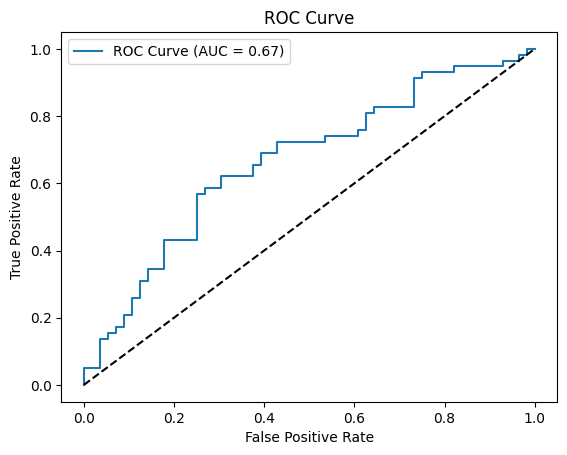


        -------------------------
        Analysis for tax: species
        -------------------------
        
We analyse data of shape (572, 207)

              precision    recall  f1-score   support

       False       0.66      0.71      0.68        56
        True       0.70      0.64      0.67        59

    accuracy                           0.68       115
   macro avg       0.68      0.68      0.68       115
weighted avg       0.68      0.68      0.68       115

ROC AUC: 0.6774
PR AUC: 0.6789


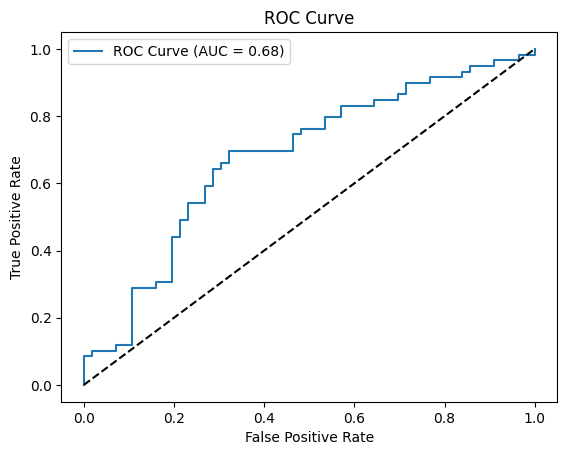

In [12]:
for tax in tax_levels:
    get_log_reg_for_taxa(tax, anketa_diseases = X_balanced, data_orig=data_orig, dataset_name="data_orig")


        -------------------------
        Analysis for tax: order
        -------------------------
        
We analyse data of shape (568, 15)

              precision    recall  f1-score   support

       False       0.59      0.48      0.53        56
        True       0.57      0.67      0.62        58

    accuracy                           0.58       114
   macro avg       0.58      0.58      0.57       114
weighted avg       0.58      0.58      0.58       114

ROC AUC: 0.6133
PR AUC: 0.6173


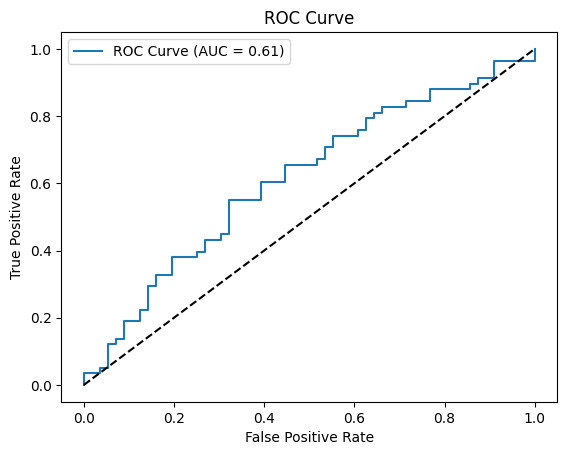


        -------------------------
        Analysis for tax: family
        -------------------------
        


We analyse data of shape (568, 18)

              precision    recall  f1-score   support

       False       0.67      0.52      0.59        56
        True       0.62      0.76      0.68        58

    accuracy                           0.64       114
   macro avg       0.65      0.64      0.63       114
weighted avg       0.65      0.64      0.63       114

ROC AUC: 0.6601
PR AUC: 0.6463


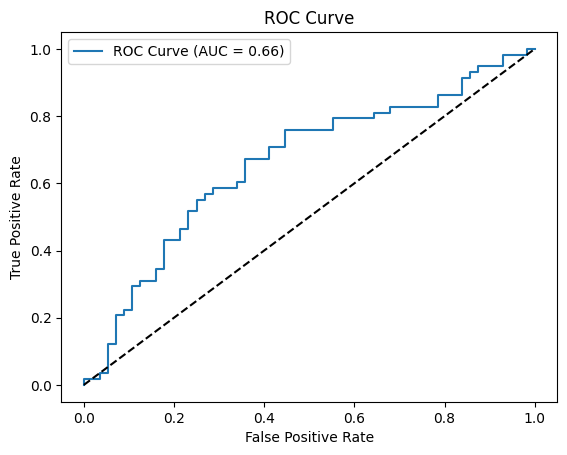


        -------------------------
        Analysis for tax: genus
        -------------------------
        
We analyse data of shape (568, 25)

              precision    recall  f1-score   support

       False       0.59      0.57      0.58        56
        True       0.60      0.62      0.61        58

    accuracy                           0.60       114
   macro avg       0.60      0.60      0.60       114
weighted avg       0.60      0.60      0.60       114

ROC AUC: 0.6493
PR AUC: 0.6368


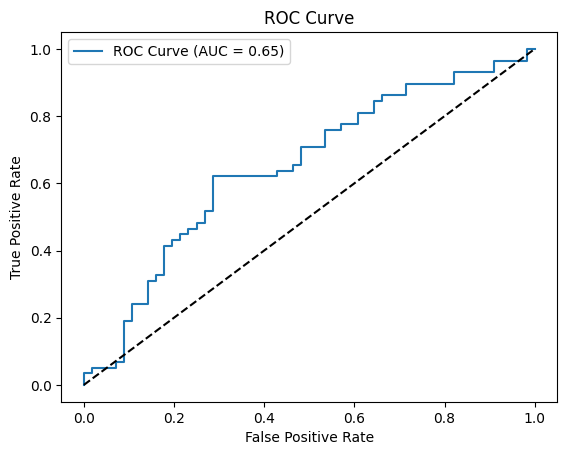


        -------------------------
        Analysis for tax: species
        -------------------------
        
We analyse data of shape (572, 84)

              precision    recall  f1-score   support

       False       0.71      0.73      0.72        56
        True       0.74      0.71      0.72        59

    accuracy                           0.72       115
   macro avg       0.72      0.72      0.72       115
weighted avg       0.72      0.72      0.72       115

ROC AUC: 0.7657
PR AUC: 0.7467


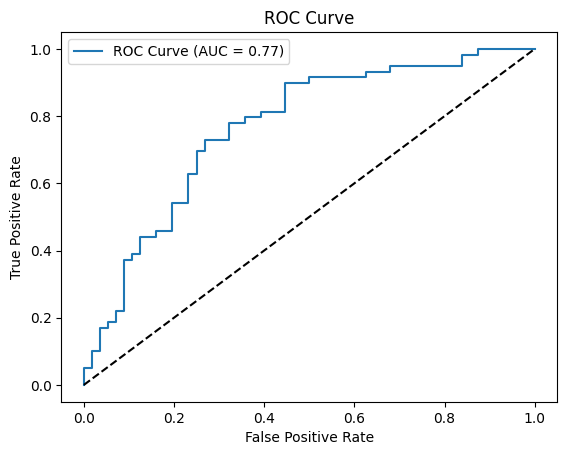

In [13]:
for tax in tax_levels:
    get_log_reg_for_taxa(tax, anketa_diseases = X_balanced, data_orig=data_pca, dataset_name="pca")

In [ ]:
for tax in tax_levels:
    assert (test_index["data_orig"][tax].index == test_index["pca"][tax].index).all()

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import Isomap
from sklearn.neighbors import NearestNeighbors

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    RocCurveDisplay,
)

intrinsic_dims = np.load(output_dir / f'intrinsic_dims_pca_strict.npy', allow_pickle=True).item()

def get_scaled_data(taxa, anketa_diseases=anketa_diseases, data_orig=data_orig):
    common_index = set(anketa_diseases["tubeid"]) & set(data_orig[taxa].index)
    anketa_diseases_filtered = anketa_diseases[anketa_diseases["tubeid"].apply(lambda x: x in common_index)].copy().sort_values(by = "tubeid")
    data_orig_taxa = data_orig[taxa].copy()
    data_orig_taxa_filtered = data_orig_taxa[data_orig_taxa.index.isin(common_index)].copy().sort_index()

    X = data_orig_taxa_filtered.values
    y = anketa_diseases_filtered["T2D"]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, stratify=y, test_size=0.2, random_state=42
    )

    scaler = StandardScaler().fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    return X_train_scaled, X_test_scaled, y_train, y_test

def get_Isomap_transformation(X_train, X_test, intrinsic_dim):
    isomap = Isomap(n_components=intrinsic_dim, n_neighbors=10).fit(X_train)
    X_train_iso = isomap.transform(X_train) 
    
    nbrs = NearestNeighbors(n_neighbors=5).fit(X_train)
    _, indices = nbrs.kneighbors(X_test)
    X_test_iso = np.mean(X_train_iso[indices], axis=1)  

    return X_train_iso, X_test_iso

def get_log_reg(X_train, X_test, y_train, y_test):
    model = GridSearchCV(
        LogisticRegression(class_weight='balanced', max_iter=1000),
        param_grid={'C': [0.01, 0.1, 1, 10]},
        cv=5,
        scoring='roc_auc'
    )
    model.fit(X_train, y_train)
    
    y_prob = model.predict_proba(X_test)[:, 1]
    print(classification_report(y_test, model.predict(X_test)))
    print("ROC AUC:", roc_auc_score(y_test, y_prob))
    
    fig, ax = plt.subplots() 
    
    RocCurveDisplay.from_estimator(model, X_test, y_test, ax=ax)
    ax.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.5)')  # Добавляем диагональ
    ax.legend(loc='lower right')
    
    plt.tight_layout()
    plt.show()


        -------------------------
        Analysis for tax: order, intrinsic_dim: 4
        -------------------------
        


              precision    recall  f1-score   support

       False       0.50      0.46      0.48        56
        True       0.52      0.55      0.53        58

    accuracy                           0.51       114
   macro avg       0.51      0.51      0.51       114
weighted avg       0.51      0.51      0.51       114

ROC AUC: 0.5036945812807881


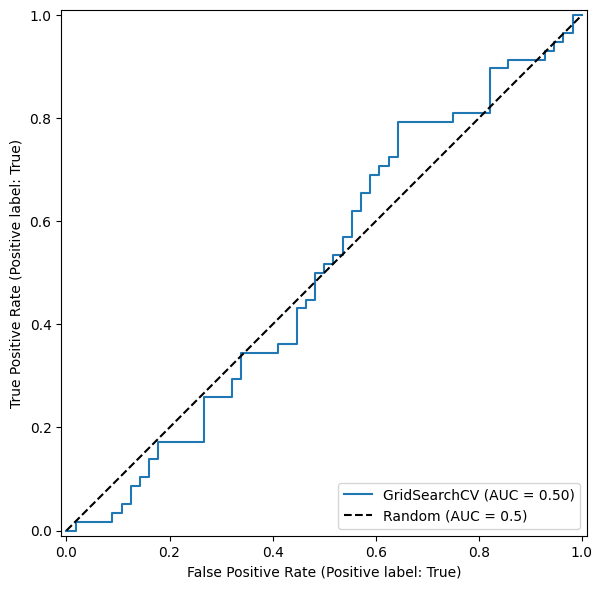


        -------------------------
        Analysis for tax: family, intrinsic_dim: 4
        -------------------------
        
              precision    recall  f1-score   support

       False       0.48      0.52      0.50        56
        True       0.49      0.45      0.47        58

    accuracy                           0.48       114
   macro avg       0.48      0.48      0.48       114
weighted avg       0.48      0.48      0.48       114

ROC AUC: 0.4972290640394088


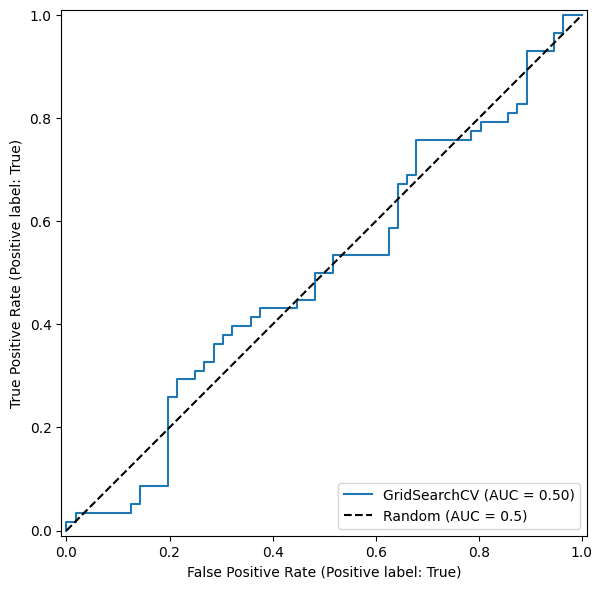


        -------------------------
        Analysis for tax: genus, intrinsic_dim: 5
        -------------------------
        
              precision    recall  f1-score   support

       False       0.51      0.55      0.53        56
        True       0.53      0.48      0.50        58

    accuracy                           0.52       114
   macro avg       0.52      0.52      0.52       114
weighted avg       0.52      0.52      0.52       114

ROC AUC: 0.49491995073891626


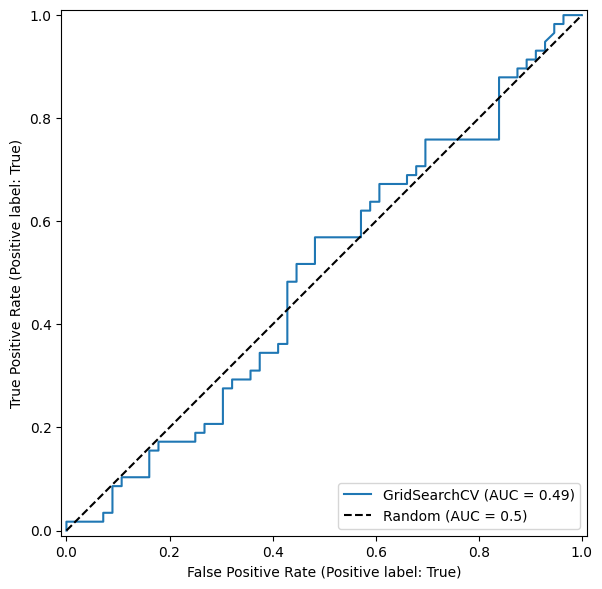


        -------------------------
        Analysis for tax: species, intrinsic_dim: 7
        -------------------------
        
              precision    recall  f1-score   support

       False       0.55      0.61      0.58        56
        True       0.58      0.53      0.55        59

    accuracy                           0.57       115
   macro avg       0.57      0.57      0.56       115
weighted avg       0.57      0.57      0.56       115

ROC AUC: 0.5941283292978208


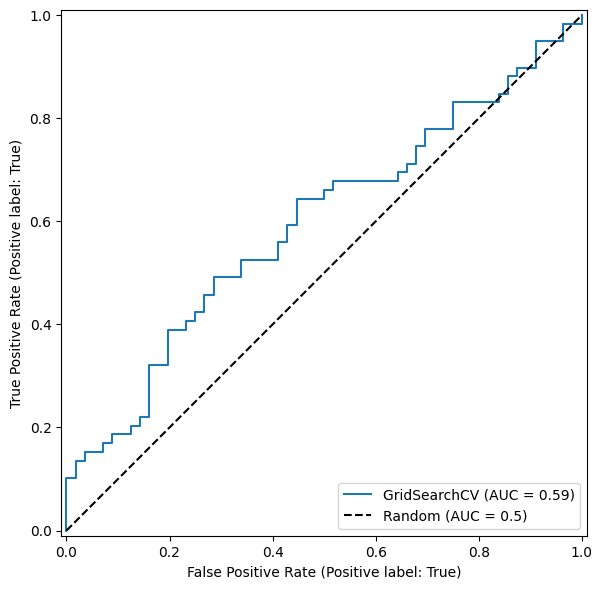

In [75]:
for tax in tax_levels:
   intrinsic_dim = intrinsic_dims[f"abundance_{tax}"]

   print(
        f"""
        -------------------------
        Analysis for tax: {tax}, intrinsic_dim: {intrinsic_dim}
        -------------------------
        """
    )
   
   X_train, X_test, y_train, y_test = get_scaled_data(tax, anketa_diseases = X_balanced, data_orig=data_pca)
   X_train_iso, X_test_iso = get_Isomap_transformation(X_train, X_test, intrinsic_dim)
   get_log_reg(X_train_iso, X_test_iso, y_train, y_test)